In [144]:
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit,to_timestamp, coalesce, col, date_format, when, isnan, count, mean as _mean, stddev as _stddev, min as _min, max as _max
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from functools import reduce
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import warnings

from sqlalchemy import create_engine, text
import pymysql

import matplotlib.pyplot as plt




from pyspark.sql.types import (
    StructType, StructField,
    FloatType, StringType
)



spark = SparkSession.builder.getOrCreate()

In [62]:
# Define la ruta base
base_path = Path("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS")

# Lista 1: Archivos .csv que contienen "AQ_SEP" en su nombre
lista_aq_sep = [archivo for archivo in base_path.rglob("*.csv") if "AQ_SEP" in archivo.name]

# Lista 2: Archivos .csv que contienen "AirQualityUnit01" en su nombre
lista_airqualityunit01 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit01" in archivo.name]

# Lista 3: Archivos .csv que contienen "AirQualityUnit02" en su nombre
lista_airqualityunit02 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit02" in archivo.name]


In [63]:
# Imprimir las listas archivos AQ_SEP
print("Archivos con 'AQ_SEP':")
for archivo in lista_aq_sep:
    print(archivo)

Archivos con 'AQ_SEP':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-11-15.

In [64]:
# Imprimir las listas archivos AirQualityUnit01
print("\nArchivos con 'AirQualityUnit01':")
for archivo in lista_airqualityunit01:
    print(archivo)


Archivos con 'AirQualityUnit01':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Julio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-07-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/7etmrairqualityobserved - AirQualityUnit01-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/7etmrairqualityobserved - AirQualityUnit01-data-2

In [65]:
# Imprimir las listas archivos AirQualityUnit02
print("\nArchivos con 'AirQualityUnit02':")
for archivo in lista_airqualityunit02:
    print(archivo)


Archivos con 'AirQualityUnit02':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/8etmrairqualityobserved - AirQualityUnit02-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/8etmrairqualityobserved - AirQualityUnit02-da

In [66]:
def detect_separator_simple(file_path, sample_size=1024):
    """
    Detecta el separador de un archivo CSV leyendo una muestra del archivo.

    Args:
        file_path (str): Ruta del archivo CSV.
        sample_size (int, optional): Número de bytes a leer para el análisis. Por defecto es 1024.

    Returns:
        str: El caracter delimitador detectado o None si no se pudo detectar.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sample = f.read(sample_size)
        dialect = csv.Sniffer().sniff(sample)
        return dialect.delimiter
    except Exception as e:
        print(f"Error al detectar el separador: {e}")
        return None


In [67]:
def load_csv_correctly(path):
    # Leer el archivo como texto
    raw_df = spark.read.text(path)
    # Obtener la primera línea
    first_line = raw_df.first()[0]
    separator = detect_separator_simple(path)
    
    if first_line and isinstance(first_line, str) and first_line.startswith("sep="):
        # Omitir la primera línea usando zipWithIndex para mantener el orden
        lines_rdd = raw_df.rdd.zipWithIndex() \
                        .filter(lambda row_index: row_index[1] > 0) \
                        .map(lambda row_index: row_index[0][0])
        
        # Leer el CSV a partir del RDD de líneas
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(lines_rdd)
    else:
        # Leer el CSV normalmente desde la ruta
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(path)
    
    return df


In [68]:
DF_LIST_AQ_SEP = [load_csv_correctly(str(path)) for path in lista_aq_sep]
DF_LIST_AQ_01 = [load_csv_correctly(str(path)) for path in lista_airqualityunit01]
DF_LIST_AQ_02 = [load_csv_correctly(str(path)) for path in lista_airqualityunit02]

In [69]:
# Función para limpiar los nombres de columnas
def clean_column_names(df):
    new_columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
    return df.toDF(*new_columns) 

In [70]:
DF_LIST_AQ_SEP = [clean_column_names(df) for df in DF_LIST_AQ_SEP]
DF_LIST_AQ_01 = [clean_column_names(df) for df in DF_LIST_AQ_01]
DF_LIST_AQ_02 = [clean_column_names(df) for df in DF_LIST_AQ_02]

In [71]:
DF_LIST_AQ_SEP

[DataFrame[time: timestamp, co_aq_sep: double, no2_aq_sep: double, o3_aq_sep: double, pm1_aq_sep: double, pm10_aq_sep: double, pm2_5_aq_sep: double, pressure_aq_sep: int, relativehumidity_aq_sep: int, temperature_aq_sep: double],
 DataFrame[time: timestamp, co_aq_sep: double, humidity_aq_sep: double, o3_aq_sep: int, pm1_aq_sep: double, pm10_aq_sep: double, pm2_5_aq_sep: double, pressure_aq_sep: int, temperature_aq_sep: double],
 DataFrame[time: timestamp, co_aq_sep: double, humidity_aq_sep: double, o3_aq_sep: double, pm1_aq_sep: double, pm10_aq_sep: double, pm2_5_aq_sep: double, pressure_aq_sep: int, temperature_aq_sep: double],
 DataFrame[time: timestamp, co_aq_sep: double, no2_aq_sep: double, o3_aq_sep: double, pm1_aq_sep: double, pm10_aq_sep: double, pm2_5_aq_sep: double, pressure_aq_sep: int, relativehumidity_aq_sep: double, temperature_aq_sep: double],
 DataFrame[time: timestamp, co_aq_sep: double, no2_aq_sep: double, o3_aq_sep: double, pm1_aq_sep: double, pm10_aq_sep: double, pm2

In [72]:
for i, df in enumerate(DF_LIST_AQ_SEP):
    print(f"DataFrame DF_LIST_AQ_SEP {i} columns: {df.columns}")

DataFrame DF_LIST_AQ_SEP 0 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 1 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 2 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 3 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 4 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 5 columns: ['time', 'co_aq_se

In [73]:
for i, df in enumerate(DF_LIST_AQ_01):
    print(f"DataFrame DF_LIST_AQ_01 {i} columns: {df.columns}")

DataFrame DF_LIST_AQ_01 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [74]:
for i, df in enumerate(DF_LIST_AQ_02):
    print(f"DataFrame DF_LIST_AQ_02 {i} columns: {df.columns}")

DataFrame DF_LIST_AQ_02 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [75]:
def standardize_df(df):
    # Lista de columnas deseadas en el orden y con los nombres estándar
    desired_order = ["time", "pm2_5", "pm10", "co", "o3", "humidity", "temperature","pm5"]
    new_columns = []
    
    # Para cada columna deseada, buscar en el DataFrame original la primera columna que contenga la palabra clave
    for keyword in desired_order:
        # Buscar candidates: columnas cuyo nombre (en minúscula) contenga la palabra clave
        candidates = [col for col in df.columns if keyword in col.lower()]
        if candidates:
            # Si existen varias, se toma la primera (podrías ajustar esto si necesitas otro criterio)
            new_columns.append(F.col(candidates[0]).alias(keyword))
        else:
            # Si no existe la columna, se agrega una columna con valores nulos
            new_columns.append(F.lit(None).alias(keyword))
    
    # Seleccionar y devolver el nuevo DataFrame con las columnas en el orden deseado
    return df.select(*new_columns)

In [76]:
DF_LIST_AQ_SEP_S = [standardize_df(df) for df in DF_LIST_AQ_SEP]
TOTAL_LIST_AQ_SEP_S = 0
for i, df in enumerate(DF_LIST_AQ_SEP_S):
    print(f"DataFrame DF_LIST_AQ_SEP_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_SEP_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_SEP_S}")
DF_LIST_AQ_SEP_S[0].show()

DataFrame DF_LIST_AQ_SEP_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2927
DataFrame DF_LIST_AQ_SEP_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 1525
DataFrame DF_LIST_AQ_SEP_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 1591
DataFrame DF_LIST_AQ_SEP_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2866
DataFrame DF_LIST_AQ_SEP_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2765
DataFrame DF_LIST_AQ_SEP_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2657
DataFrame DF_LIST_AQ_SEP_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2959
DataFrame DF_LIST_AQ_SEP_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2859
DataFrame DF_LIST_AQ_SEP

In [77]:
DF_LIST_AQ_01_S = [standardize_df(df) for df in DF_LIST_AQ_01]
TOTAL_LIST_AQ_01_S = 0
for i, df in enumerate(DF_LIST_AQ_01_S):
    print(f"DataFrame DF_LIST_AQ_01_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_01_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_01_S}")
DF_LIST_AQ_01_S[0].show()

DataFrame DF_LIST_AQ_01_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2841
DataFrame DF_LIST_AQ_01_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 12962
DataFrame DF_LIST_AQ_01_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14216
DataFrame DF_LIST_AQ_01_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14879
DataFrame DF_LIST_AQ_01_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14376
DataFrame DF_LIST_AQ_01_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14168
DataFrame DF_LIST_AQ_01_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 13346
DataFrame DF_LIST_AQ_01_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 15215
DataFrame DF_LIST_AQ_01_S

In [78]:
DF_LIST_AQ_02_S = [standardize_df(df) for df in DF_LIST_AQ_02]
TOTAL_LIST_AQ_02_S = 0
for i, df in enumerate(DF_LIST_AQ_02_S):
    print(f"DataFrame DF_LIST_AQ_02_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_02_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_02_S}")
DF_LIST_AQ_02_S[0].show()

DataFrame DF_LIST_AQ_02_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 2803
DataFrame DF_LIST_AQ_02_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 6471
DataFrame DF_LIST_AQ_02_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 3564
DataFrame DF_LIST_AQ_02_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14385
DataFrame DF_LIST_AQ_02_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 13991
DataFrame DF_LIST_AQ_02_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 13471
DataFrame DF_LIST_AQ_02_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14786
DataFrame DF_LIST_AQ_02_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature', 'pm5'] count: 14245
DataFrame DF_LIST_AQ_02_S 8

In [79]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_SEP_S
DF_AQ_SEP = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_SEP_S)
print(f"Total de filas en todos los DF_AQ_SEP: {DF_AQ_SEP.count()}")
DF_AQ_SEP.show()

Total de filas en todos los DF_AQ_SEP: 32172
+-------------------+-----+----+----+---+--------+-----------+----+
|               time|pm2_5|pm10|  co| o3|humidity|temperature| pm5|
+-------------------+-----+----+----+---+--------+-----------+----+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|NULL|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|NULL|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|NULL|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|NULL|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|NULL|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|NULL|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|NULL|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|NULL|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|NULL|
|2024-03-15 02:26:34|  0.6| 0.6|19.2|0.1|  -999.0|        9.9|NULL|
|2024-03-15 02:41:34|  0.5| 0.5|19.7|0.1|  -999.0|        9.7|NULL|
|20

In [80]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_01_S
DF_AQ_1 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_01_S)
print(f"Total de filas en todos los DF_AQ_1: {DF_AQ_1.count()}")
DF_AQ_1.show()

Total de filas en todos los DF_AQ_1: 181913
+----------------+-----+----+----+----+--------+-----------+----+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature| pm5|
+----------------+-----+----+----+----+--------+-----------+----+
|19/03/2024 22:08| -999|-999|-999|-999|  -999.0|     -998.0|-999|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|-999|
|08/04/2024 18:39|   44|  58|   2|-999|    60.3|       20.3|  29|
|08/04/2024 18:41|   46|  56|   3|-999|    60.3|       20.3|  30|
|08/04/2024 18:43|   46|  56|   4|-999|    60.3|       20.3|  30|
|08/04/2024 18:45|   46|  61|   5|-999|    60.4|       20.3|  28|
|08/04/2024 18:48|   45|  61|   6|-999|    60.5|       20.3|  27|
|08/04/2024 18:50|   45|  61|   7|-999|    60.6|       20.3|  27|
|08/04/2024 18:52|   46|  61|   8|-999|    60.7|       20.4|  28|
|08/04/2024 18:54|   44|  53|   9|-999|    60.7|       20.4|  28|
|08/04/2024 18:56|   44|  53|  10|-999|    60.7|       20.4|  28|
|08/04/2024 19:00|   43|  52|  1

In [81]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_02_S
DF_AQ_2 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_02_S)
print(f"Total de filas en todos los DF_AQ_2: {DF_AQ_2.count()}")
DF_AQ_2.show()

Total de filas en todos los DF_AQ_2: 148552
+----------------+-----+----+----+----+--------+-----------+----+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature| pm5|
+----------------+-----+----+----+----+--------+-----------+----+
|19/03/2024 22:09| -999|-999|-999|-999|  -999.0|     -998.0|-999|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|-999|
|08/04/2024 20:18|   39|  45|   1|-999|    78.0|       19.0|  30|
|08/04/2024 20:20|   42|  54|   2|-999|    78.1|       19.3|  28|
|08/04/2024 20:46|   40|  47|   1|-999|    72.0|       20.3|  30|
|08/04/2024 20:48|   45|  59|   2|-999|    71.1|       20.4|  30|
|08/04/2024 20:53|   44|  56|   4|-999|    69.5|       20.5|  29|
|08/04/2024 20:55|   41|  51|   5|-999|    69.1|       20.5|  27|
|08/04/2024 20:57|   41|  52|   6|-999|    68.7|       20.6|  28|
|08/04/2024 20:59|   40|  52|   7|-999|    68.4|       20.6|  27|
|08/04/2024 21:05|   38|  48|  10|-999|    67.7|       20.8|  26|
|08/04/2024 21:07|   38|  51|  1

In [82]:
DF_AQ_SEP.show()

+-------------------+-----+----+----+---+--------+-----------+----+
|               time|pm2_5|pm10|  co| o3|humidity|temperature| pm5|
+-------------------+-----+----+----+---+--------+-----------+----+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|NULL|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|NULL|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|NULL|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|NULL|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|NULL|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|NULL|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|NULL|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|NULL|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|NULL|
|2024-03-15 02:26:34|  0.6| 0.6|19.2|0.1|  -999.0|        9.9|NULL|
|2024-03-15 02:41:34|  0.5| 0.5|19.7|0.1|  -999.0|        9.7|NULL|
|2024-03-15 02:56:34|  0.4| 0.4|17.7|0.1|  -999.

In [83]:
# Para cada DataFrame
for df_name, df in [("DF_AQ_SEP", DF_AQ_SEP), ("DF_AQ_1", DF_AQ_1), ("DF_AQ_2", DF_AQ_2)]:
    total_rows = df.count()
    unique_rows = df.distinct().count()
    duplicates = total_rows - unique_rows
    
    print(f"{df_name}:")
    print(f"  Total filas: {total_rows}")
    print(f"  Filas únicas: {unique_rows}")
    print(f"  Filas duplicadas: {duplicates}")
    print(f"  ¿Tiene duplicados?: {'Sí' if duplicates > 0 else 'No'}")
    print()

DF_AQ_SEP:
  Total filas: 32172
  Filas únicas: 31666
  Filas duplicadas: 506
  ¿Tiene duplicados?: Sí



DF_AQ_1:
  Total filas: 181913
  Filas únicas: 179442
  Filas duplicadas: 2471
  ¿Tiene duplicados?: Sí



DF_AQ_2:
  Total filas: 148552
  Filas únicas: 146065
  Filas duplicadas: 2487
  ¿Tiene duplicados?: Sí



In [84]:
# Remover duplicados y reasignar los DataFrames
DF_AQ_SEP = DF_AQ_SEP.distinct()
DF_AQ_1 = DF_AQ_1.distinct()
DF_AQ_2 = DF_AQ_2.distinct()
print(f"  DF_AQ_SEP => : {DF_AQ_SEP.count()}")
print(f"  DF_AQ_1 => : {DF_AQ_1.count()}")
print(f"  DF_AQ_2 => : {DF_AQ_2.count()}")

  DF_AQ_SEP => : 31666


  DF_AQ_1 => : 179442


  DF_AQ_2 => : 146065


In [85]:
# Crear una condición que sea True cuando todas las columnas sean null

CONDITION = reduce(lambda acc, col: acc & F.col(col).isNull(), DF_AQ_2.columns, F.lit(True))

# Filtrar y contar las filas que cumplen la condición
DF_AQ_SEP_ALL_NULL = DF_AQ_SEP.filter(CONDITION).count()
DF_AQ_1_ALL_NULL = DF_AQ_1.filter(CONDITION).count()
DF_AQ_2_ALL_NULL = DF_AQ_2.filter(CONDITION).count()


print(" DF_AQ_SEP -> Cantidad de filas completamente null:", DF_AQ_SEP_ALL_NULL)
print(" DF_AQ_1 -> Cantidad de filas completamente null:", DF_AQ_1_ALL_NULL)
print(" DF_AQ_2 -> Cantidad de filas completamente null:", DF_AQ_2_ALL_NULL)

 DF_AQ_SEP -> Cantidad de filas completamente null: 0
 DF_AQ_1 -> Cantidad de filas completamente null: 0
 DF_AQ_2 -> Cantidad de filas completamente null: 0


In [86]:
def standardize_time_column(df):
    """
    Procesa la columna 'time' de un DataFrame y crea una nueva columna 'time_format'
    con el formato 'yyyy-MM-dd HH:mm:ss'.
    
    Considera varios formatos de fecha/hora:
      - dd/MM/yyyy H:mm       (Ej: 19/03/2024 22:09 o 01/04/2024 9:33)
      - yyyy-MM-dd H:mm:ss     (Ej: 2024-03-15 00:11:34)
      - yyyy-MM-dd H:mm        (Ej: 2024-03-15 11:34)
    """
    # Intenta convertir la columna "time" usando los diferentes formatos
    df = df.withColumn(
        "time_ts",
        coalesce(
            to_timestamp(col("time"), "dd/MM/yyyy H:mm"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm:ss"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm")
        )
    )
    
    # Formatea el timestamp al formato deseado y crea la nueva columna "time_format"
    df = df.withColumn("time_format", date_format(col("time_ts"), "yyyy-MM-dd HH:mm:ss"))
    
    # Elimina la columna intermedia si ya no es necesaria
    df = df.drop("time_ts")
    
    return df


In [87]:
#se crea una funcion que estandariza las fechas y agrega una nueva columna
DF_AQ_SEP = standardize_time_column(DF_AQ_SEP)
DF_AQ_1   = standardize_time_column(DF_AQ_1)
DF_AQ_2   = standardize_time_column(DF_AQ_2)


In [88]:
#DF_AQ_SEP.show()
#DF_AQ_1.show()
#DF_AQ_2.show()

In [89]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_SEP.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_SEP.filter(col("time_format").isNull()).count()
print("DF_AQ_SEP - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+---+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|pm5|time_format|
+----+-----+----+---+---+--------+-----------+---+-----------+
+----+-----+----+---+---+--------+-----------+---+-----------+

DF_AQ_SEP - Número de filas con time_format null: 0


In [90]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_1.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_1.filter(col("time_format").isNull()).count()
print("DF_AQ_1 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+---+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|pm5|time_format|
+----+-----+----+---+---+--------+-----------+---+-----------+
+----+-----+----+---+---+--------+-----------+---+-----------+



DF_AQ_1 - Número de filas con time_format null: 0


In [59]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_2.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_2.filter(col("time_format").isNull()).count()
print("DF_AQ_2 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+---+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|pm5|time_format|
+----+-----+----+---+---+--------+-----------+---+-----------+
+----+-----+----+---+---+--------+-----------+---+-----------+



DF_AQ_2 - Número de filas con time_format null: 0


In [91]:
#despues de verificar que la columna time_format no tiene valores nulos se procede a eliminar la columna time
DF_AQ_SEP = DF_AQ_SEP.drop("time")
#DF_AQ_SEP = DF_AQ_SEP.drop("pm5")
DF_AQ_1 = DF_AQ_1.drop("time")
DF_AQ_2 = DF_AQ_2.drop("time")

In [ ]:
def analizar_nulls_y_graficar(df, titulo="Porcentaje de Valores Nulos por Columna", 
                              figsize=(10, 8), color='skyblue'):
    """import matplotlib.pyplot as plt
from pyspark.sql.functions import col, isnan, when, count
    Analiza valores nulos en un DataFrame de PySpark y crea una gráfica de barras.
    
    Parámetros:
    -----------
    df : pyspark.sql.DataFrame
        DataFrame de PySpark a analizar
    titulo : str
        Título de la gráfica
    figsize : tuple
        Tamaño de la figura (ancho, alto)
    color : str
        Color de las barras
    
    Retorna:
    --------
    dict : Diccionario con estadísticas de nulls por columna
    """
    
    # Obtener el número total de filas
    total_filas = df.count()
    
    if total_filas == 0:
        print("El DataFrame está vacío")
        return {}
    
    # Calcular nulls por columna
    null_counts = {}
    null_percentages = {}
    
    # Para cada columna, contar nulls
    for columna in df.columns:
        # Contar nulls (incluyendo NaN para columnas numéricas)
        null_count = df.select(
            count(when(col(columna).isNull() | isnan(col(columna)), columna)).alias('nulls')
        ).collect()[0]['nulls']
        
        null_counts[columna] = null_count
        null_percentages[columna] = (null_count / total_filas) * 100
    
    # Mostrar estadísticas
    print("=" * 60)
    print(f"ANÁLISIS DE VALORES NULOS")
    print("=" * 60)
    print(f"Total de filas: {total_filas:,}")
    print(f"Total de columnas: {len(df.columns)}")
    print()
    
    print("Estadísticas por columna:")
    print("-" * 50)
    for columna in df.columns:
        print(f"{columna:<25} | Nulls: {null_counts[columna]:>6,} ({null_percentages[columna]:>6.2f}%)")
    
    # Crear la gráfica
    columnas = list(null_percentages.keys())
    porcentajes = list(null_percentages.values())
    
    # Configurar la figura
    plt.figure(figsize=figsize)
    
    # Crear barras horizontales
    bars = plt.barh(columnas, porcentajes, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Personalizar la gráfica
    plt.xlabel('Porcentaje de Valores Nulos (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Columnas', fontsize=12, fontweight='bold')
    plt.title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Configurar el eje X de 0 a 100%
    plt.xlim(0, 100)
    
    # Agregar líneas de cuadrícula
    plt.grid(True, axis='x', alpha=0.3, linestyle='--')
    
    # Agregar etiquetas de porcentaje en las barras
    for i, (bar, porcentaje) in enumerate(zip(bars, porcentajes)):
        if porcentaje > 5:  # Solo mostrar etiqueta si el porcentaje es > 5%
            plt.text(porcentaje/2, i, f'{porcentaje:.1f}%', 
                    ha='center', va='center', fontweight='bold', color='black')
        elif porcentaje > 0:  # Para porcentajes pequeños, mostrar al final de la barra
            plt.text(porcentaje + 1, i, f'{porcentaje:.1f}%', 
                    ha='left', va='center', fontsize=9)
    
    # Ajustar diseño
    plt.tight_layout()
    
    # Mostrar la gráfica
    plt.show()
    
    # Retornar estadísticas
    estadisticas = {
        'total_filas': total_filas,
        'null_counts': null_counts,
        'null_percentages': null_percentages,
        'columna_mas_nulls': max(null_percentages, key=null_percentages.get),
        'columna_menos_nulls': min(null_percentages, key=null_percentages.get)
    }
    
    print(f"\nColumna con más nulls: {estadisticas['columna_mas_nulls']} ({null_percentages[estadisticas['columna_mas_nulls']]:.2f}%)")
    print(f"Columna con menos nulls: {estadisticas['columna_menos_nulls']} ({null_percentages[estadisticas['columna_menos_nulls']]:.2f}%)")
    
    return estadisticas

# Función alternativa para manejar solo valores NULL (sin NaN)
def analizar_nulls_y_graficar_solo_null(df, titulo="Porcentaje de Valores NULL por Columna", 
                                        figsize=(10, 8), color='lightcoral'):
    """
    Similar a la función anterior pero solo cuenta valores NULL, no NaN.
    Útil si quieres distinguir entre NULL y NaN.
    """
    
    total_filas = df.count()
    
    if total_filas == 0:
        print("El DataFrame está vacío")
        return {}
    
    # Calcular nulls por columna (solo NULL, no NaN)
    null_counts = {}
    null_percentages = {}
    
    for columna in df.columns:
        null_count = df.select(
            count(when(col(columna).isNull(), columna)).alias('nulls')
        ).collect()[0]['nulls']
        
        null_counts[columna] = null_count
        null_percentages[columna] = (null_count / total_filas) * 100
    
    # El resto del código es igual...
    # [Similar implementation as the main function]
    
    return analizar_nulls_y_graficar(df, titulo, figsize, color)

# Ejemplo de uso:
# estadisticas = analizar_nulls_y_graficar(DF_AQ_SEP, "Análisis de Nulls - DF_AQ_SEP")
# estadisticas = analizar_nulls_y_graficar(DF_AQ_1, "Análisis de Nulls - DF_AQ_1")
# estadisticas = analizar_nulls_y_graficar(DF_AQ_2, "Análisis de Nulls - DF_AQ_2")

In [160]:
def analizar_nulls_grouped_horiz(
    dfs: list,
    labels: list,
    titulo="Porcentaje de Nulls por Columna",
    figsize=(12, 8),
    colors=('skyblue','salmon','lightgreen'),
    bar_height=0.2
):
    """
    Grafica barras horizontales agrupadas (una al lado de la otra) para varios DataFrames,
    con barras delgadas y etiquetas de porcentaje (omitidas si son 0%).
    """
    if not (len(dfs) == len(labels) == len(colors)):
        raise ValueError("dfs, labels y colors deben tener la misma longitud.")

    columnas = dfs[0].columns
    n_cols   = len(columnas)
    n_dfs    = len(dfs)

    # 1) Calcular porcentajes de nulls
    porcentajes = []
    for df in dfs:
        total = df.count()
        pct = []
        for c in columnas:
            n_null = df.select(
                count(when(col(c).isNull() | isnan(col(c)), c)).alias("n")
            ).collect()[0]["n"]
            pct.append((n_null/total)*100 if total>0 else 0)
        porcentajes.append(pct)

    # 2) Preparar offsets en Y
    y = np.arange(n_cols)
    offsets = (np.arange(n_dfs) - (n_dfs-1)/2) * bar_height

    # 3) Dibujar
    fig, ax = plt.subplots(figsize=figsize)
    for i, pct in enumerate(porcentajes):
        y_pos = y + offsets[i]
        ax.barh(
            y=y_pos,
            width=pct,
            height=bar_height,
            color=colors[i],
            label=labels[i],
            edgecolor='black',
            alpha=0.8
        )
        # Etiquetas sólo si pct > 0
        for j, val in enumerate(pct):
            # redondea a 1 decimal y comprueba
            if round(val, 1) > 0:
                txt = f"{val:.1f}%"
                ax.text(
                    val + 1,
                    y_pos[j],
                    txt,
                    va='center',
                    fontsize=9
                )

    # 4) Ajustes finales
    ax.set_yticks(y)
    ax.set_yticklabels(columnas, fontsize=11)
    ax.set_xlim(0, 100)
    ax.set_xlabel("Porcentaje de Nulls (%)", fontweight='bold')
    ax.set_title(titulo, fontweight='bold', pad=15)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.legend(title="DataFrames", loc='upper right')
    plt.tight_layout()
    plt.show()


In [97]:
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [102]:
DF_AQ_1 = DF_AQ_1.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_1 = DF_AQ_1.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_1 = DF_AQ_1.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_1 = DF_AQ_1.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_1 = DF_AQ_1.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_1 = DF_AQ_1.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)
DF_AQ_1 = DF_AQ_1.withColumn("pm5",
    when(col("pm5") <= -990, None).otherwise(col("pm5"))
)

In [99]:
DF_AQ_2 = DF_AQ_2.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_2 = DF_AQ_2.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_2 = DF_AQ_2.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_2 = DF_AQ_2.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_2 = DF_AQ_2.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_2 = DF_AQ_2.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)
DF_AQ_2 = DF_AQ_2.withColumn("pm5",
    when(col("pm5") <= -990, None).otherwise(col("pm5"))
)

ANÁLISIS DE VALORES NULOS
Total de filas: 31,666
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:     57 (  0.18%)
pm10                      | Nulls:     54 (  0.17%)
co                        | Nulls:     57 (  0.18%)
o3                        | Nulls:     57 (  0.18%)
humidity                  | Nulls:  5,749 ( 18.16%)
temperature               | Nulls:    414 (  1.31%)
pm5                       | Nulls: 31,666 (100.00%)
time_format               | Nulls:      0 (  0.00%)


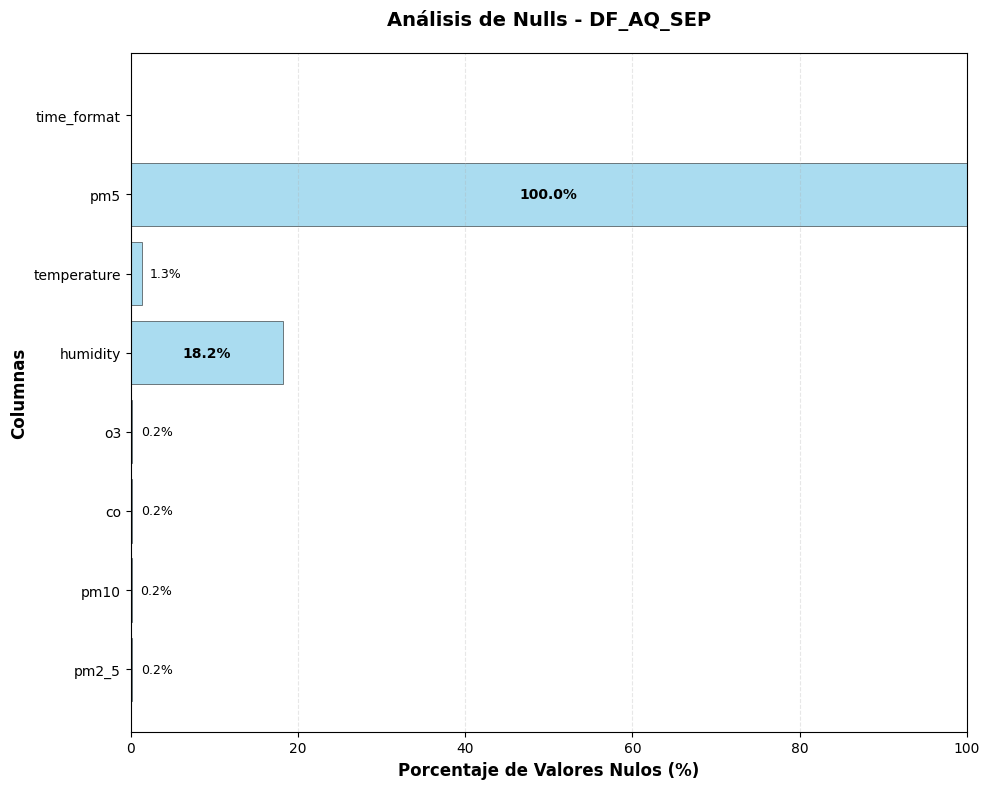


Columna con más nulls: pm5 (100.00%)
Columna con menos nulls: time_format (0.00%)


In [100]:
# Para analizar cada uno de tus DataFrames:
estadisticas_sep = analizar_nulls_y_graficar(DF_AQ_SEP, "Análisis de Nulls - DF_AQ_SEP")
#estadisticas_1 = analizar_nulls_y_graficar(DF_AQ_1, "Análisis de Nulls - DF_AQ_1") 
#estadisticas_2 = analizar_nulls_y_graficar(DF_AQ_2, "Análisis de Nulls - DF_AQ_2")

ANÁLISIS DE VALORES NULOS
Total de filas: 179,442
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:     51 (  0.03%)
pm10                      | Nulls:     51 (  0.03%)
co                        | Nulls:     51 (  0.03%)
o3                        | Nulls: 164,319 ( 91.57%)
humidity                  | Nulls:     51 (  0.03%)
temperature               | Nulls:     51 (  0.03%)
pm5                       | Nulls:     51 (  0.03%)
time_format               | Nulls:      0 (  0.00%)


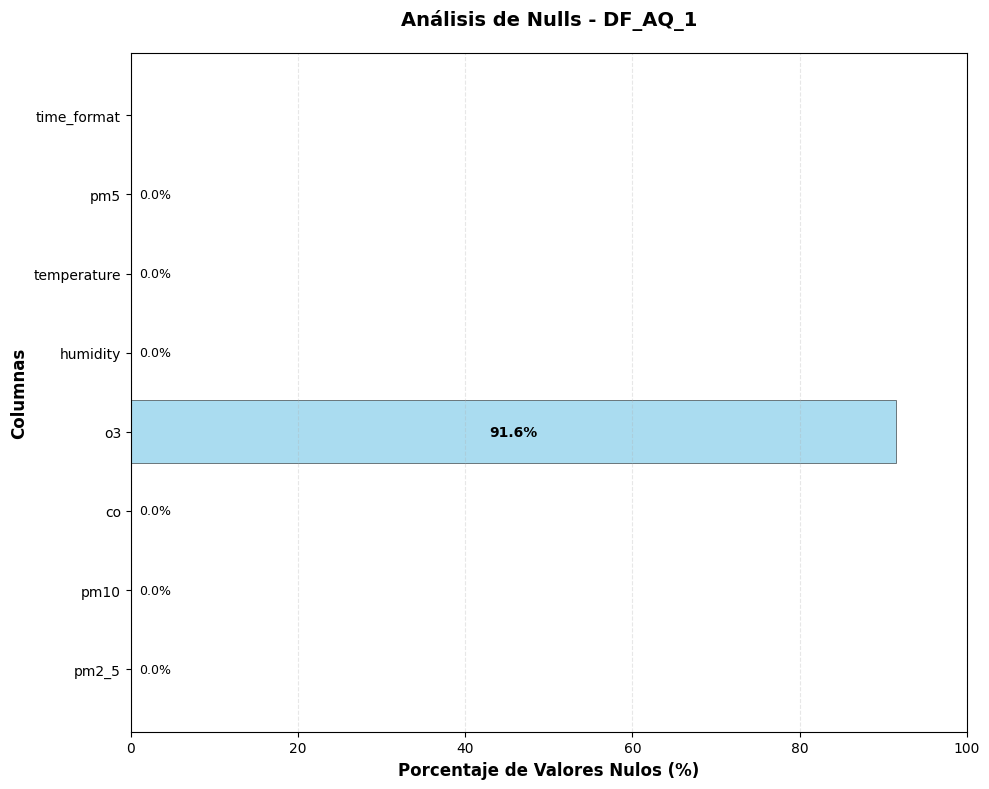


Columna con más nulls: o3 (91.57%)
Columna con menos nulls: time_format (0.00%)


In [103]:
estadisticas_1 = analizar_nulls_y_graficar(DF_AQ_1, "Análisis de Nulls - DF_AQ_1") 

ANÁLISIS DE VALORES NULOS
Total de filas: 146,065
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:     50 (  0.03%)
pm10                      | Nulls:     50 (  0.03%)
co                        | Nulls:     50 (  0.03%)
o3                        | Nulls: 131,678 ( 90.15%)
humidity                  | Nulls:     50 (  0.03%)
temperature               | Nulls:     50 (  0.03%)
pm5                       | Nulls:     50 (  0.03%)
time_format               | Nulls:      0 (  0.00%)


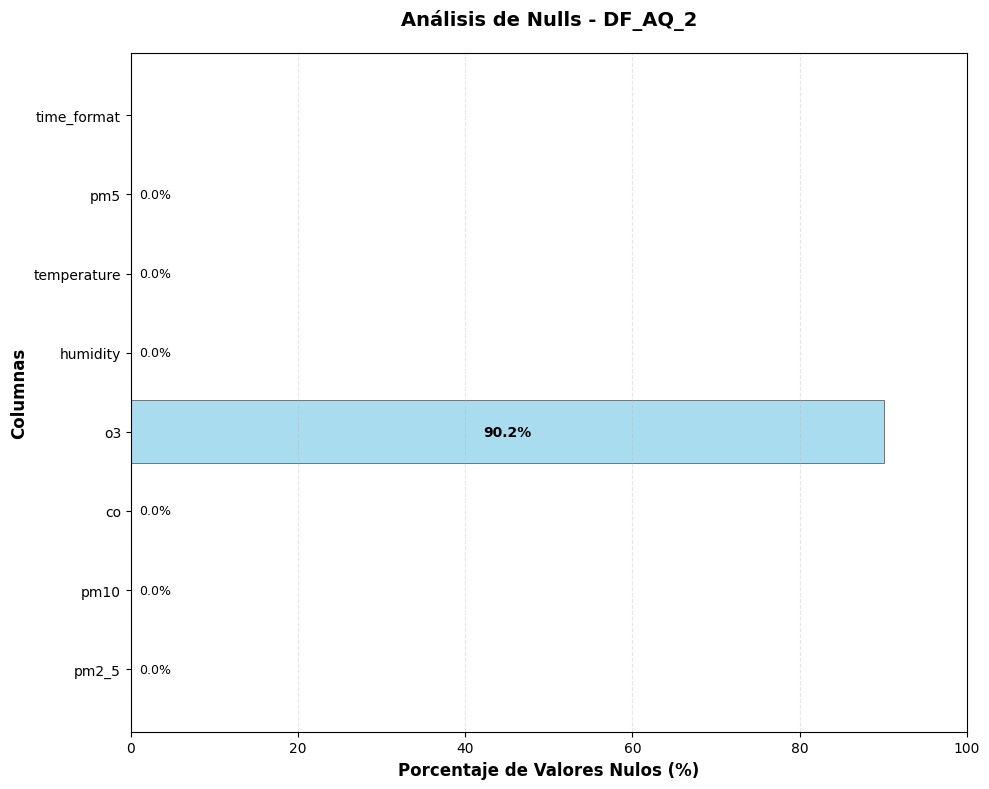


Columna con más nulls: o3 (90.15%)
Columna con menos nulls: time_format (0.00%)


In [104]:
estadisticas_2 = analizar_nulls_y_graficar(DF_AQ_2, "Análisis de Nulls - DF_AQ_2")

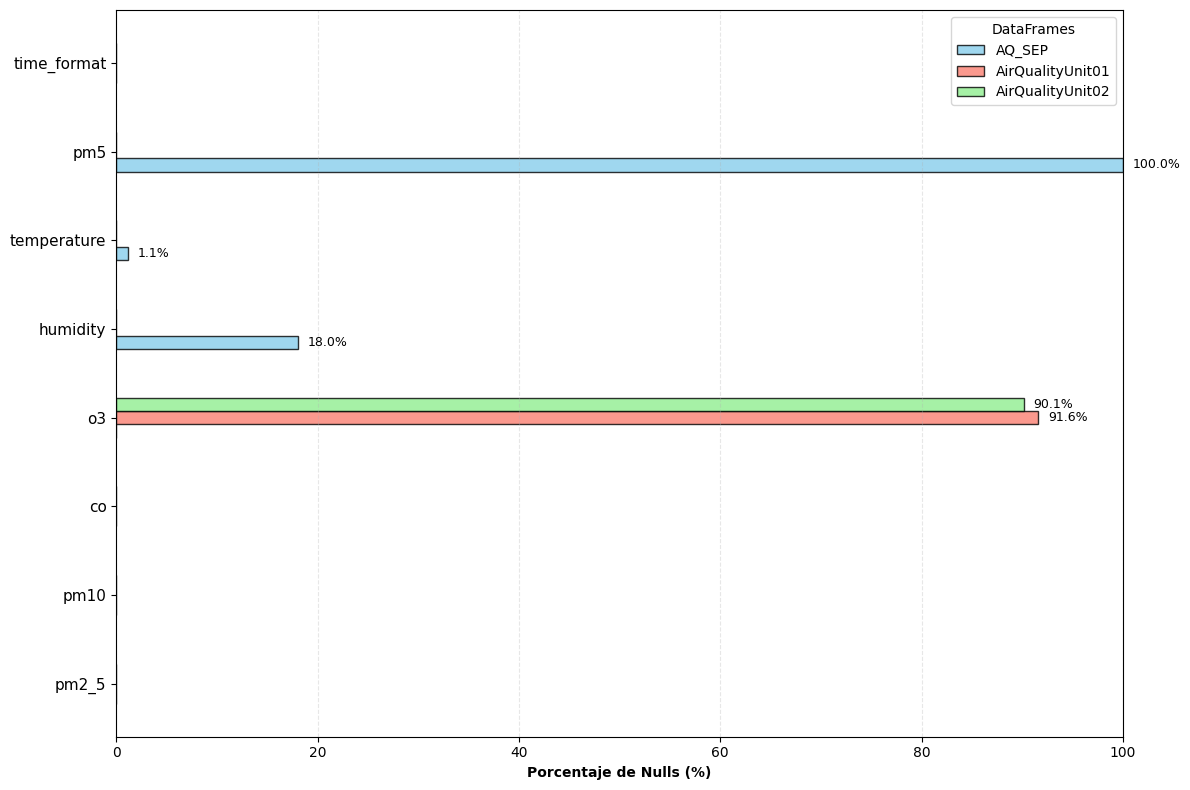

In [163]:
analizar_nulls_grouped_horiz(
    dfs        = [DF_AQ_SEP, DF_AQ_1, DF_AQ_2],
    labels     = ['AQ_SEP',     'AirQualityUnit01',    'AirQualityUnit02'],
    titulo     = "",
    bar_height = 0.15   # ajusta este valor para hacer las barras más o menos gruesas
)



In [105]:
# FILTRAR FILAS CON VALORES NULOS EN COLUMNAS DIFERENTES AL TIME
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature","pm5"]
# Construir la condición: cada columna debe ser null
condition = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))
# Filtrar el DataFrame
DF_AQ_SEP_null_rows = DF_AQ_SEP.filter(condition)
DF_AQ_2_null_rows = DF_AQ_2.filter(condition)
DF_AQ_1_null_rows = DF_AQ_1.filter(condition)
# Mostrar el resultado
print(DF_AQ_SEP_null_rows.count())
print(DF_AQ_1_null_rows.count())
print(DF_AQ_2_null_rows.count())

53
51
50


In [106]:
#AHORA SE ELIMINAN LAS FILAS CON VALORES NULOS
# Lista de columnas a verificar
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature","pm5"]

# Construir la condición que identifica filas donde todas las columnas son null
condition_all_null = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))

# Filtrar el DataFrame eliminando aquellas filas que cumplan la condición
DF_AQ_SEP = DF_AQ_SEP.filter(~condition_all_null)
DF_AQ_1 = DF_AQ_1.filter(~condition_all_null)
DF_AQ_2 = DF_AQ_2.filter(~condition_all_null)

ANÁLISIS DE VALORES NULOS
Total de filas: 31,613
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:      4 (  0.01%)
pm10                      | Nulls:      1 (  0.00%)
co                        | Nulls:      4 (  0.01%)
o3                        | Nulls:      4 (  0.01%)
humidity                  | Nulls:  5,696 ( 18.02%)
temperature               | Nulls:    361 (  1.14%)
pm5                       | Nulls: 31,613 (100.00%)
time_format               | Nulls:      0 (  0.00%)


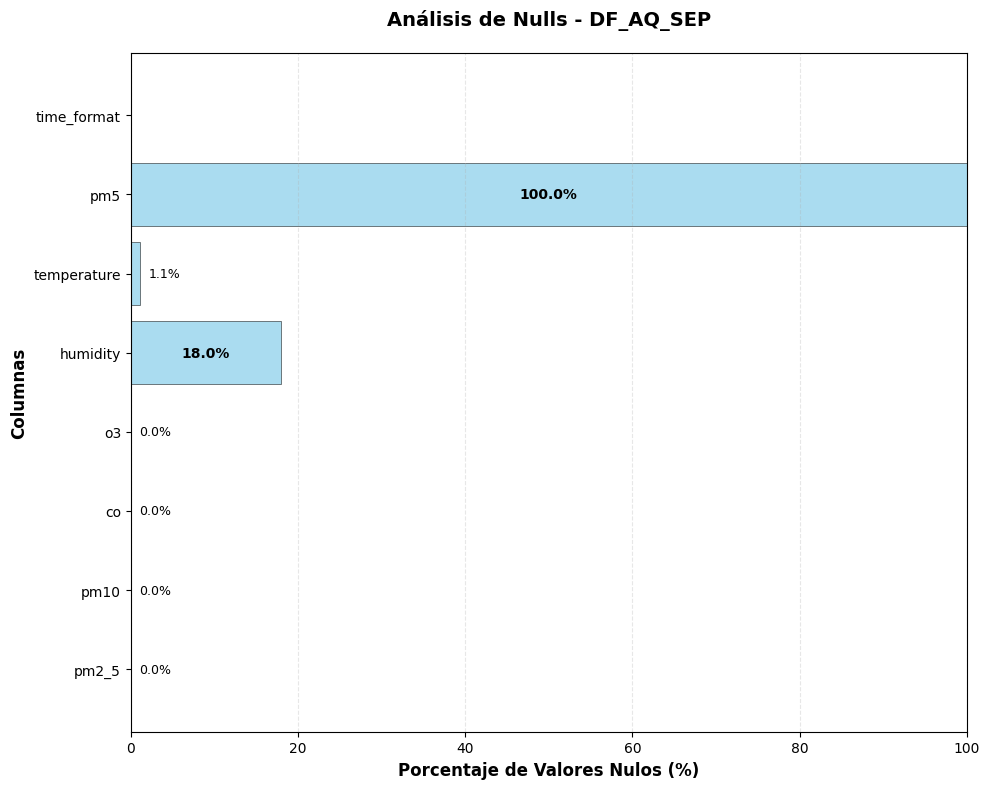


Columna con más nulls: pm5 (100.00%)
Columna con menos nulls: time_format (0.00%)


In [108]:
estadisticas_sep = analizar_nulls_y_graficar(DF_AQ_SEP, "Análisis de Nulls - DF_AQ_SEP")

ANÁLISIS DE VALORES NULOS
Total de filas: 179,391
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:      0 (  0.00%)
pm10                      | Nulls:      0 (  0.00%)
co                        | Nulls:      0 (  0.00%)
o3                        | Nulls: 164,268 ( 91.57%)
humidity                  | Nulls:      0 (  0.00%)
temperature               | Nulls:      0 (  0.00%)
pm5                       | Nulls:      0 (  0.00%)
time_format               | Nulls:      0 (  0.00%)


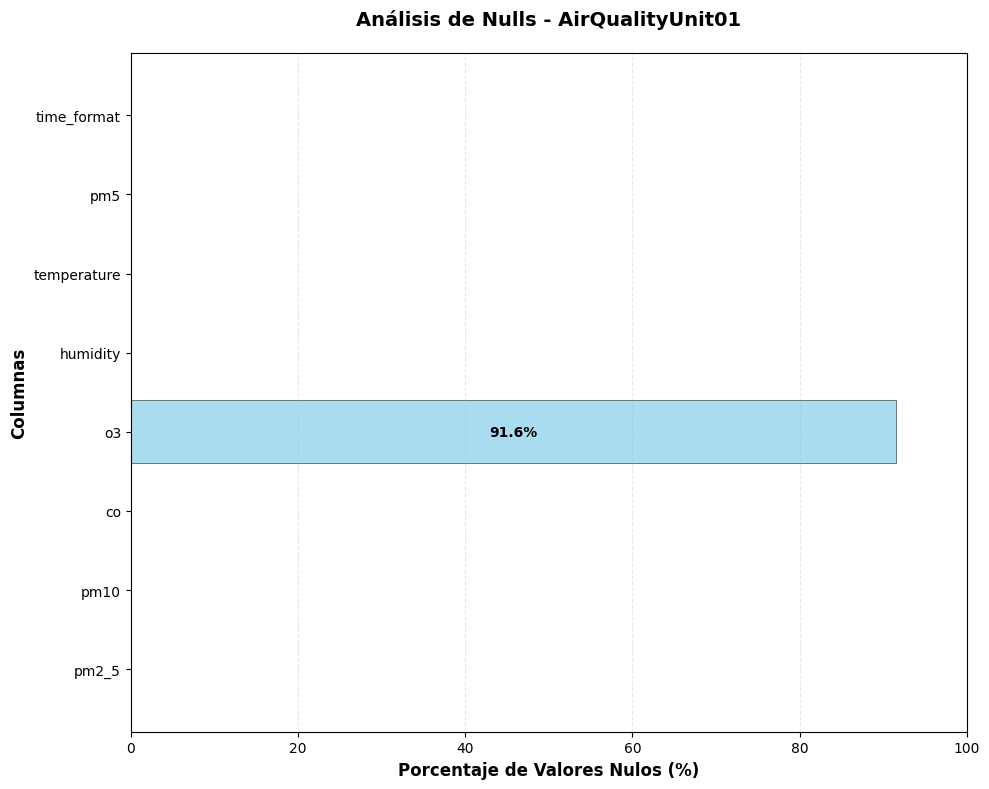


Columna con más nulls: o3 (91.57%)
Columna con menos nulls: pm2_5 (0.00%)


In [109]:
estadisticas_1 = analizar_nulls_y_graficar(DF_AQ_1, "Análisis de Nulls - AirQualityUnit01") 

ANÁLISIS DE VALORES NULOS
Total de filas: 146,015
Total de columnas: 8

Estadísticas por columna:
--------------------------------------------------
pm2_5                     | Nulls:      0 (  0.00%)
pm10                      | Nulls:      0 (  0.00%)
co                        | Nulls:      0 (  0.00%)
o3                        | Nulls: 131,628 ( 90.15%)
humidity                  | Nulls:      0 (  0.00%)
temperature               | Nulls:      0 (  0.00%)
pm5                       | Nulls:      0 (  0.00%)
time_format               | Nulls:      0 (  0.00%)


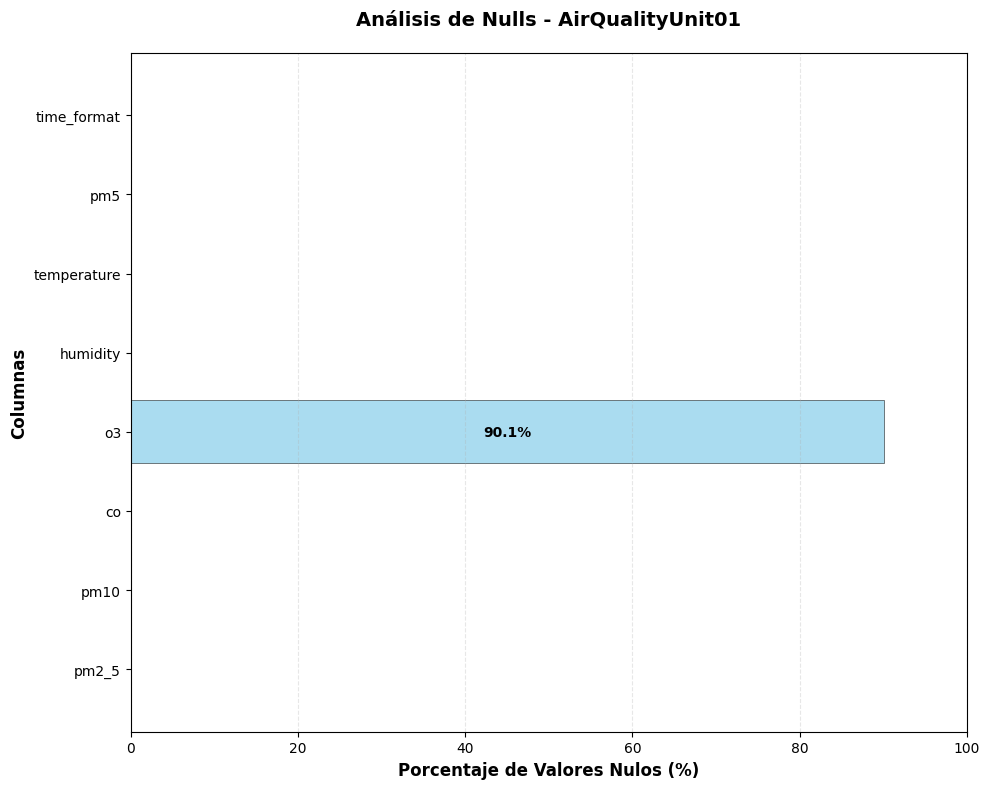


Columna con más nulls: o3 (90.15%)
Columna con menos nulls: pm2_5 (0.00%)


In [110]:
estadisticas_2 = analizar_nulls_y_graficar(DF_AQ_2, "Análisis de Nulls - AirQualityUnit01")

In [139]:
# 1) Convierte a pandas
DF_AQ_SEP_PD = DF_AQ_SEP.toPandas()
DF_AQ_1_PD = DF_AQ_1.toPandas()

# 2) Ahora puedes usar pdf['pm2_5'].median()
ref_pm25_median = DF_AQ_1_PD['pm2_5'].median()
ref_pm10_median = DF_AQ_1_PD['pm10'].median()

# Calcular medianas del sensor a normalizar
target_pm25_median = DF_AQ_SEP_PD['pm2_5'].median()
target_pm10_median = DF_AQ_SEP_PD['pm10'].median()

# Calcular factores de normalización
factor_pm25 = ref_pm25_median / target_pm25_median
factor_pm10 = ref_pm10_median / target_pm10_median

DF_AQ_SEP_PD['pm2_5'] = DF_AQ_SEP_PD['pm2_5'] * factor_pm25
DF_AQ_SEP_PD['pm10'] = DF_AQ_SEP_PD['pm10'] * factor_pm10


In [143]:
DF_AQ_SEP_PD.dtypes

pm2_5          float64
pm10           float64
co             float64
o3             float64
humidity       float64
temperature    float64
pm5             object
time_format     object
dtype: object

In [145]:

# 2) Define el esquema explícito según los dtypes de pandas
schema = StructType([
    StructField("pm2_5",      FloatType(),  True),
    StructField("pm10",       FloatType(),  True),
    StructField("co",         FloatType(),  True),
    StructField("o3",         FloatType(),  True),
    StructField("humidity",   FloatType(),  True),
    StructField("temperature",FloatType(),  True),
    StructField("pm5",        StringType(), True),
    StructField("time_format",StringType(), True),
])

# 3) Supón que tu DataFrame de pandas se llama `pdf`
#    Convierte a DataFrame de Spark con el esquema
DF_AQ_SEP_MED = spark.createDataFrame(DF_AQ_SEP_PD, schema=schema)

# 4) Verifica esquema y algunos registros
DF_AQ_SEP_MED.printSchema()
DF_AQ_SEP_MED.show(5, truncate=False)

root
 |-- pm2_5: float (nullable = true)
 |-- pm10: float (nullable = true)
 |-- co: float (nullable = true)
 |-- o3: float (nullable = true)
 |-- humidity: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- pm5: string (nullable = true)
 |-- time_format: string (nullable = true)

+---------+----+----+---+--------+-----------+----+-------------------+
|pm2_5    |pm10|co  |o3 |humidity|temperature|pm5 |time_format        |
+---------+----+----+---+--------+-----------+----+-------------------+
|11.111111|12.0|33.6|0.1|NaN     |14.6       |NULL|2024-03-15 22:26:36|
|5.5555553|6.0 |12.2|0.1|NaN     |9.5        |NULL|2024-03-18 02:11:58|
|5.5555553|6.0 |16.1|0.1|NaN     |8.5        |NULL|2024-03-18 04:57:01|
|11.111111|12.0|24.9|0.4|NaN     |21.0       |NULL|2024-03-19 17:12:33|
|12.962963|16.0|31.8|0.2|NaN     |17.4       |NULL|2024-03-26 18:30:02|
+---------+----+----+---+--------+-----------+----+-------------------+
only showing top 5 rows



In [118]:
# Variables globales
engine = None

def connect_to_db():
    global engine
    user = 'root'
    password = 'rootpassword'
    host = '127.0.0.1'
    port = 3309
    db = 'AIRQUALITY'

    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(connection_string)
    print("✅ Conexión a MySQL creada.")


In [119]:
def create_tables_if_not_exist():
    with engine.connect() as conn:
        # Tabla DF_AQ_SEP
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS DF_AQ_SEP (
                pm2_5 DOUBLE,
                pm10 DOUBLE,
                co DOUBLE,
                o3 DOUBLE,
                pm5 INT,
                humidity DOUBLE,
                temperature DOUBLE,
                time_format VARCHAR(50)
            )
        """))

        # Tabla DF_AQ_1
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS DF_AQ_1 (
                pm2_5 INT,
                pm10 INT,
                co INT,
                o3 INT,
                humidity DOUBLE,
                temperature DOUBLE,
                pm5 INT,
                time_format VARCHAR(50)
            )
        """))

        # Tabla DF_AQ_2
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS DF_AQ_2 (
                pm2_5 INT,
                pm10 INT,
                co INT,
                o3 INT,
                humidity DOUBLE,
                temperature DOUBLE,
                pm5 INT,
                time_format VARCHAR(50)
            )
        """))

        print("✅ Tablas verificadas y creadas si era necesario.")


In [120]:
def insert_dataframe(df, table_name):
    if engine is None:
        raise Exception("Primero debes establecer la conexión con `connect_to_db()`.")

    try:
        df.to_sql(name=table_name, con=engine, if_exists='append', index=False)
        print(f"✅ Datos insertados en la tabla {table_name}.")
    except Exception as e:
        print(f"❌ Error al insertar datos en la tabla {table_name}: {e}")


In [147]:
connect_to_db()
create_tables_if_not_exist()

# Insertar los dataframes limpiando primero cada tabla
insert_dataframe(DF_AQ_SEP.toPandas(), "DF_AQ_SEP_NO_MED")
insert_dataframe(DF_AQ_SEP_MED.toPandas(), "DF_AQ_SEP")
insert_dataframe(DF_AQ_1.toPandas(), "DF_AQ_1")
insert_dataframe(DF_AQ_2.toPandas(), "DF_AQ_2")


✅ Conexión a MySQL creada.
✅ Tablas verificadas y creadas si era necesario.
✅ Datos insertados en la tabla DF_AQ_SEP_NO_MED.
✅ Datos insertados en la tabla DF_AQ_SEP.
✅ Datos insertados en la tabla DF_AQ_1.


✅ Datos insertados en la tabla DF_AQ_2.


DF_AQ_SEP.show()

In [123]:
DF_AQ_2.show()

+-----+----+---+----+--------+-----------+---+-------------------+
|pm2_5|pm10| co|  o3|humidity|temperature|pm5|        time_format|
+-----+----+---+----+--------+-----------+---+-------------------+
|   20|  25| 14|NULL|    69.4|       20.9| 11|2024-04-09 02:37:00|
|   16|  16| 29|NULL|    71.0|       20.6| 10|2024-04-09 04:13:00|
|   30|  31| 17|NULL|    58.2|       19.1| 20|2024-04-09 18:44:00|
|   15|  17|  9|NULL|    69.4|       20.0|  9|2024-04-10 02:31:00|
|   30|  33|  6|NULL|    68.6|       19.0| 17|2024-04-10 22:54:00|
|    9|   9| 13|NULL|    22.8|       37.8|  8|2024-04-11 13:08:00|
|   48|  59| 26|NULL|    55.5|       19.1| 30|2024-04-12 08:50:00|
|   44|  56| 20|NULL|    64.2|       12.8| 28|2024-04-12 23:34:00|
|   51|  65| 23|NULL|    71.9|       11.8| 31|2024-04-13 07:10:00|
|   20|  20| 27|NULL|    34.5|       25.1| 15|2024-04-13 11:35:00|
|   45|  56| 13|NULL|    54.6|       17.7| 29|2024-04-13 19:39:00|
|   34|  45|  4|NULL|    66.8|       13.4| 22|2024-04-14 03:53